# 머신 러닝 교과서 3판

# 17장 - 새로운 데이터 합성을 위한 생성적 적대 신경망 (1/2)

**아래 링크를 통해 이 노트북을 주피터 노트북 뷰어(nbviewer.jupyter.org)로 보거나 구글 코랩(colab.research.google.com)에서 실행할 수 있습니다.**

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://nbviewer.org/github/rickiepark/python-machine-learning-book-3rd-edition/blob/master/ch17/ch17_part1.ipynb"><img src="https://jupyter.org/assets/share.png" width="60" />주피터 노트북 뷰어로 보기</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/python-machine-learning-book-3rd-edition/blob/master/ch17/ch17_part1.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩(Colab)에서 실행하기</a>
  </td>
</table>

### 목차

- 생성적 적대 신경망 소개
    - 오토인코더
    - 새로운 데이터 합성을 위한 생성 모델
    - GAN으로 새로운 샘플 생성하기
    - GAN의 생성자와 판별자 손실 함수 이해하기
- 밑바닥부터 GAN 모델 구현하기
    - 구글 코랩에서 GAN 모델 훈련하기
    - 생성자와 판별자 신경망 구현하기
    - 훈련 데이터셋 정의하기
    - GAN 모델 훈련하기

In [1]:
from IPython.display import Image

# 생성적 적대 신경망 소개

## 오토인코더

In [2]:
Image(url='https://git.io/JLAQ2', width=500)

## 새로운 데이터 합성을 위한 생성 모델

In [3]:
Image(url='https://git.io/JLAQH', width=700)

## GAN으로 새로운 샘플 생성하기

In [4]:
Image(url='https://git.io/JLAQ7', width=700)

## GAN의 생성자와 판별자 손실 함수 이해하기

In [5]:
Image(url='https://git.io/JLAQF', width=800)

# 밑바닥부터 GAN 모델 구현하기

## 구글 코랩에서 GAN 모델 훈련하기

In [6]:
Image(url='https://git.io/JLAQb', width=700)

In [7]:
Image(url='https://git.io/JLAQN', width=600)

In [8]:
Image(url='https://git.io/JLAQA', width=600)

In [9]:
import tensorflow as tf
print(tf.__version__)

print("GPU 여부:", len(tf.config.list_physical_devices('GPU')) > 0)

if tf.config.list_physical_devices('GPU'):
    device_name = tf.test.gpu_device_name()
else:
    device_name = 'cpu:0'
    
print(device_name)

2.6.0
GPU 여부: True
/device:GPU:0


In [10]:
tf.config.experimental.get_memory_usage('GPU:0')

Instructions for updating:
Use tf.config.experimental.get_memory_info(device)['current'] instead.


0

In [11]:
!nvidia-smi

Sat Aug 21 11:07:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P0    29W /  70W |    220MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [12]:
!lsb_release -a

No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 18.04.5 LTS
Release:	18.04
Codename:	bionic


In [13]:
#from google.colab import drive
#drive.mount('/content/drive/')

## 생성자와 판별자 신경망 구현하기

In [14]:
Image(url='https://git.io/JLAQp', width=600)

In [15]:
Image(url='https://git.io/JLAQh', width=600)

In [16]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

In [17]:
## 생성자 함수를 정의합니다:
def make_generator_network(
        num_hidden_layers=1,
        num_hidden_units=100,
        num_output_units=784):
    model = tf.keras.Sequential()
    for i in range(num_hidden_layers):
        model.add(
            tf.keras.layers.Dense(
                units=num_hidden_units, 
                use_bias=False)
            )
        model.add(tf.keras.layers.LeakyReLU())
        
    model.add(tf.keras.layers.Dense(
        units=num_output_units, activation='tanh'))
    return model

## 판별자 함수를 정의합니다:
def make_discriminator_network(
        num_hidden_layers=1,
        num_hidden_units=100,
        num_output_units=1):
    model = tf.keras.Sequential()
    for i in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(units=num_hidden_units))
        model.add(tf.keras.layers.LeakyReLU())
        model.add(tf.keras.layers.Dropout(rate=0.5))
        
    model.add(
        tf.keras.layers.Dense(
            units=num_output_units, 
            activation=None)
        )
    return model

In [18]:
image_size = (28, 28)
z_size = 20
mode_z = 'uniform'  # 'uniform' vs. 'normal'
gen_hidden_layers = 1
gen_hidden_size = 100
disc_hidden_layers = 1
disc_hidden_size = 100

tf.random.set_seed(1)

gen_model = make_generator_network(
    num_hidden_layers=gen_hidden_layers, 
    num_hidden_units=gen_hidden_size,
    num_output_units=np.prod(image_size))

gen_model.build(input_shape=(None, z_size))
gen_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               2000      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 784)               79184     
Total params: 81,184
Trainable params: 81,184
Non-trainable params: 0
_________________________________________________________________


In [19]:
disc_model = make_discriminator_network(
    num_hidden_layers=disc_hidden_layers,
    num_hidden_units=disc_hidden_size)

disc_model.build(input_shape=(None, np.prod(image_size)))
disc_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 100)               78500     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 100)               0         
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 78,601
Trainable params: 78,601
Non-trainable params: 0
_________________________________________________________________


## 훈련 데이터셋 정의하기

In [20]:
mnist_bldr = tfds.builder('mnist')
mnist_bldr.download_and_prepare()
mnist = mnist_bldr.as_dataset(shuffle_files=False)

def preprocess(ex, mode='uniform'):
    image = ex['image']
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.reshape(image, [-1])
    image = image*2 - 1.0
    if mode == 'uniform':
        input_z = tf.random.uniform(
            shape=(z_size,), minval=-1.0, maxval=1.0)
    elif mode == 'normal':
        input_z = tf.random.normal(shape=(z_size,))
    return input_z, image



mnist_trainset = mnist['train']

print('전처리 전:  ')
example = next(iter(mnist_trainset))['image']
print('dtype: ', example.dtype, ' 최소: {} 최대: {}'.format(np.min(example), np.max(example)))

mnist_trainset = mnist_trainset.map(preprocess)

print('전처리 후:  ')
example = next(iter(mnist_trainset))[0]
print('dtype: ', example.dtype, ' 최소: {} 최대: {}'.format(np.min(example), np.max(example)))

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.
전처리 전:  
dtype:  <dtype: 'uint8'>  최소: 0 최대: 255
전처리 후:  
dtype:  <dtype: 'float32'>  최소: -0.8737728595733643 최대: 0.9460210800170898


 * **데이터 흐름을 단계별로 밟아보기**

In [21]:
mnist_trainset = mnist_trainset.batch(32, drop_remainder=True)
input_z, input_real = next(iter(mnist_trainset))
print('input-z -- 크기:', input_z.shape)
print('input-real -- 크기:', input_real.shape)

g_output = gen_model(input_z)
print('생성자 출력 -- 크기:', g_output.shape)

d_logits_real = disc_model(input_real)
d_logits_fake = disc_model(g_output)
print('판별자 (진짜) -- 크기:', d_logits_real.shape)
print('판별자 (가짜) -- 크기:', d_logits_fake.shape)

input-z -- 크기: (32, 20)
input-real -- 크기: (32, 784)
생성자 출력 -- 크기: (32, 784)
판별자 (진짜) -- 크기: (32, 1)
판별자 (가짜) -- 크기: (32, 1)


## GAN 모델 훈련하기

In [22]:
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)

## 생성자 손실
g_labels_real = tf.ones_like(d_logits_fake)
g_loss = loss_fn(y_true=g_labels_real, y_pred=d_logits_fake)
print('생성자 손실: {:.4f}'.format(g_loss))

## 판별자 손실
d_labels_real = tf.ones_like(d_logits_real)
d_labels_fake = tf.zeros_like(d_logits_fake)

d_loss_real = loss_fn(y_true=d_labels_real, y_pred=d_logits_real)
d_loss_fake = loss_fn(y_true=d_labels_fake, y_pred=d_logits_fake)
print('판별자 손실: 진짜 {:.4f} 가짜 {:.4f}'
      .format(d_loss_real.numpy(), d_loss_fake.numpy()))

생성자 손실: 0.7355
판별자 손실: 진짜 1.5073 가짜 0.6583


 * **최종 훈련**

In [23]:
import time


num_epochs = 100
batch_size = 64
image_size = (28, 28)
z_size = 20
mode_z = 'uniform'
gen_hidden_layers = 1
gen_hidden_size = 100
disc_hidden_layers = 1
disc_hidden_size = 100

tf.random.set_seed(1)
np.random.seed(1)


if mode_z == 'uniform':
    fixed_z = tf.random.uniform(
        shape=(batch_size, z_size),
        minval=-1, maxval=1)
elif mode_z == 'normal':
    fixed_z = tf.random.normal(
        shape=(batch_size, z_size))


def create_samples(g_model, input_z):
    g_output = g_model(input_z, training=False)
    images = tf.reshape(g_output, (batch_size, *image_size))    
    return (images+1)/2.0

## 데이터셋 준비
mnist_trainset = mnist['train']
mnist_trainset = mnist_trainset.map(
    lambda ex: preprocess(ex, mode=mode_z))

mnist_trainset = mnist_trainset.shuffle(10000)
mnist_trainset = mnist_trainset.batch(
    batch_size, drop_remainder=True)

## 모델 준비
with tf.device(device_name):
    gen_model = make_generator_network(
        num_hidden_layers=gen_hidden_layers, 
        num_hidden_units=gen_hidden_size,
        num_output_units=np.prod(image_size))
    gen_model.build(input_shape=(None, z_size))

    disc_model = make_discriminator_network(
        num_hidden_layers=disc_hidden_layers,
        num_hidden_units=disc_hidden_size)
    disc_model.build(input_shape=(None, np.prod(image_size)))

## 손실 함수와 옵티마이저:
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
g_optimizer = tf.keras.optimizers.Adam()
d_optimizer = tf.keras.optimizers.Adam()

all_losses = []
all_d_vals = []
epoch_samples = []

start_time = time.time()
for epoch in range(1, num_epochs+1):
    epoch_losses, epoch_d_vals = [], []
    for i,(input_z,input_real) in enumerate(mnist_trainset):
        
        ## 생성자 손실을 계산합니다
        with tf.GradientTape() as g_tape:
            g_output = gen_model(input_z)
            d_logits_fake = disc_model(g_output, training=True)
            labels_real = tf.ones_like(d_logits_fake)
            g_loss = loss_fn(y_true=labels_real, y_pred=d_logits_fake)
            
        # g_loss의 그래디언트를 계산합니다
        g_grads = g_tape.gradient(g_loss, gen_model.trainable_variables)
        
        # 최적화: 그래디언트를 적용합니다
        g_optimizer.apply_gradients(
            grads_and_vars=zip(g_grads, gen_model.trainable_variables))

        ## 판별자 손실을 계산합니다
        with tf.GradientTape() as d_tape:
            d_logits_real = disc_model(input_real, training=True)

            d_labels_real = tf.ones_like(d_logits_real)
            
            d_loss_real = loss_fn(
                y_true=d_labels_real, y_pred=d_logits_real)

            d_logits_fake = disc_model(g_output, training=True)
            d_labels_fake = tf.zeros_like(d_logits_fake)

            d_loss_fake = loss_fn(
                y_true=d_labels_fake, y_pred=d_logits_fake)

            d_loss = d_loss_real + d_loss_fake

        ## d_loss의 그래디언트를 계산합니다
        d_grads = d_tape.gradient(d_loss, disc_model.trainable_variables)
        
        ## 최적화: 그래디언트를 적용합니다
        d_optimizer.apply_gradients(
            grads_and_vars=zip(d_grads, disc_model.trainable_variables))
                           
        epoch_losses.append(
            (g_loss.numpy(), d_loss.numpy(), 
             d_loss_real.numpy(), d_loss_fake.numpy()))
        
        d_probs_real = tf.reduce_mean(tf.sigmoid(d_logits_real))
        d_probs_fake = tf.reduce_mean(tf.sigmoid(d_logits_fake))
        epoch_d_vals.append((d_probs_real.numpy(), d_probs_fake.numpy()))        
    all_losses.append(epoch_losses)
    all_d_vals.append(epoch_d_vals)
    print(
        '에포크 {:03d} | 시간 {:.2f} min | 평균 손실 >>'
        ' 생성자/판별자 {:.4f}/{:.4f} [판별자-진짜: {:.4f} 판별자-가짜: {:.4f}]'
        .format(
            epoch, (time.time() - start_time)/60, 
            *list(np.mean(all_losses[-1], axis=0))))
    epoch_samples.append(
        create_samples(gen_model, fixed_z).numpy())

에포크 001 | 시간 0.43 min | 평균 손실 >> 생성자/판별자 2.8619/0.2890 [판별자-진짜: 0.0333 판별자-가짜: 0.2557]
에포크 002 | 시간 0.80 min | 평균 손실 >> 생성자/판별자 5.2556/0.3357 [판별자-진짜: 0.1082 판별자-가짜: 0.2275]
에포크 003 | 시간 1.18 min | 평균 손실 >> 생성자/판별자 3.2048/0.6823 [판별자-진짜: 0.3033 판별자-가짜: 0.3791]
에포크 004 | 시간 1.56 min | 평균 손실 >> 생성자/판별자 2.2370/0.8360 [판별자-진짜: 0.4271 판별자-가짜: 0.4089]
에포크 005 | 시간 1.94 min | 평균 손실 >> 생성자/판별자 2.1083/0.8131 [판별자-진짜: 0.4385 판별자-가짜: 0.3746]
에포크 006 | 시간 2.31 min | 평균 손실 >> 생성자/판별자 1.7609/0.9193 [판별자-진짜: 0.4988 판별자-가짜: 0.4204]
에포크 007 | 시간 2.69 min | 평균 손실 >> 생성자/판별자 1.5653/0.9947 [판별자-진짜: 0.5352 판별자-가짜: 0.4595]
에포크 008 | 시간 3.07 min | 평균 손실 >> 생성자/판별자 1.5385/0.9672 [판별자-진짜: 0.5279 판별자-가짜: 0.4393]
에포크 009 | 시간 3.44 min | 평균 손실 >> 생성자/판별자 1.5485/0.9928 [판별자-진짜: 0.5411 판별자-가짜: 0.4517]
에포크 010 | 시간 3.82 min | 평균 손실 >> 생성자/판별자 1.2947/1.1119 [판별자-진짜: 0.5925 판별자-가짜: 0.5194]
에포크 011 | 시간 4.20 min | 평균 손실 >> 생성자/판별자 1.2626/1.1474 [판별자-진짜: 0.5971 판별자-가짜: 0.5503]
에포크 012 | 시간 4.58 min | 평균 손실 >> 생성자/판별자 1.

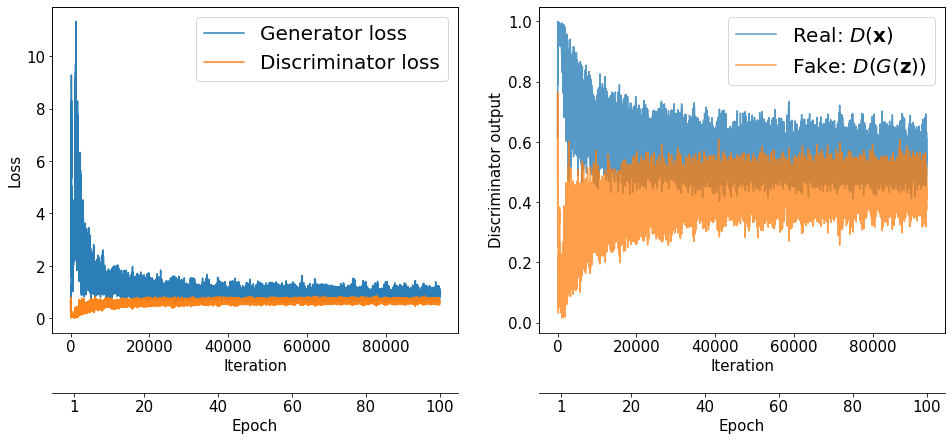

In [24]:
import itertools


fig = plt.figure(figsize=(16, 6))

## 손실 그래프
ax = fig.add_subplot(1, 2, 1)
g_losses = [item[0] for item in itertools.chain(*all_losses)]
d_losses = [item[1]/2.0 for item in itertools.chain(*all_losses)]
plt.plot(g_losses, label='Generator loss', alpha=0.95)
plt.plot(d_losses, label='Discriminator loss', alpha=0.95)
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Loss', size=15)

epochs = np.arange(1, 101)
epoch2iter = lambda e: e*len(all_losses[-1])
epoch_ticks = [1, 20, 40, 60, 80, 100]
newpos = [epoch2iter(e) for e in epoch_ticks]
ax2 = ax.twiny()
ax2.set_xticks(newpos)
ax2.set_xticklabels(epoch_ticks)
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 60))
ax2.set_xlabel('Epoch', size=15)
ax2.set_xlim(ax.get_xlim())
ax.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)

## 판별자의 출력
ax = fig.add_subplot(1, 2, 2)
d_vals_real = [item[0] for item in itertools.chain(*all_d_vals)]
d_vals_fake = [item[1] for item in itertools.chain(*all_d_vals)]
plt.plot(d_vals_real, alpha=0.75, label=r'Real: $D(\mathbf{x})$')
plt.plot(d_vals_fake, alpha=0.75, label=r'Fake: $D(G(\mathbf{z}))$')
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Discriminator output', size=15)

ax2 = ax.twiny()
ax2.set_xticks(newpos)
ax2.set_xticklabels(epoch_ticks)
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 60))
ax2.set_xlabel('Epoch', size=15)
ax2.set_xlim(ax.get_xlim())
ax.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)

plt.show()

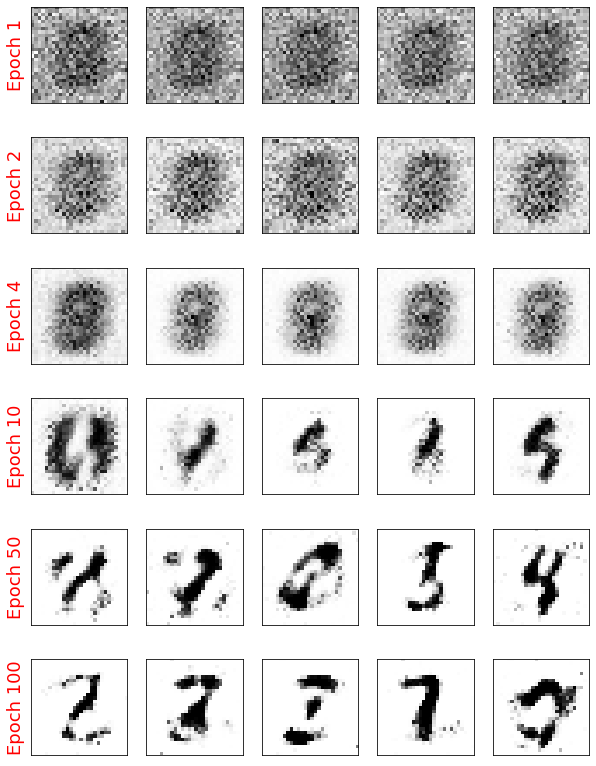

In [25]:
selected_epochs = [1, 2, 4, 10, 50, 100]
fig = plt.figure(figsize=(10, 14))
for i,e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(6, 5, i*5+j+1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.text(
                -0.06, 0.5, 'Epoch {}'.format(e),
                rotation=90, size=18, color='red',
                horizontalalignment='right',
                verticalalignment='center', 
                transform=ax.transAxes)
        
        image = epoch_samples[e-1][j]
        ax.imshow(image, cmap='gray_r')

plt.show()